In [1]:
# =====================================================
#     Tên: Real Estate Price Prediction
#     Nghiên cứu khoa học: "Nghiên cứu tối ưu mô hình kết hợp
#     trong việc dự đoán giá nhà tại Hà Nội"
#     Mô hình sử dụng: Radom Forest & XGBoost
# =====================================================

In [2]:
# -------------------------------------------------
# 0. CÀI THƯ VIỆN (Colab cài mới nhất đã hỗ trợ GPU)
# -------------------------------------------------
!pip install -U xgboost optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 6.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 21.1 MB/s eta 0:00:00


In [3]:
# -------------------------------------------------
# 1. IMPORT & ĐỌC DỮ LIỆU
# -------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path

# --- tải/đọc CSV ---
DATA_PATH = Path("/kaggle/input/dataggg/data_processing.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Không tìm thấy file: {DATA_PATH}")
data = pd.read_csv(DATA_PATH)

target = "price"
y = data[target]
X = data.drop(columns=[target])

In [4]:
# -------------------------------------------------
# 2. TIỀN XỬ LÝ: ColumnTransformer + Pipeline
# -------------------------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_cols  = X.select_dtypes(include=["int64", "float64"]).columns
bool_cols = X.select_dtypes(include=["bool"]).columns  # 1‑hot district

preprocess = ColumnTransformer([
    ("num",  StandardScaler(),   num_cols),
    ("bool", "passthrough",      bool_cols)  # giữ nguyên 0/1
])

In [5]:
# -------------------------------------------------
# 3. ĐỊNH NGHĨA RMSLE & SCORER
# -------------------------------------------------
from sklearn.metrics import make_scorer, mean_squared_log_error

def rmsle(y_true, y_pred):
    # Cắt giá trị về >= 0 để tránh log(âm)
    y_true = np.clip(y_true, 0, None)
    y_pred = np.clip(y_pred, 0, None)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Tạo scorer cho cross_val_score,
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [6]:
# -------------------------------------------------
# 4. TÁCH TRAIN / TEST (80 % / 20 %)
# -------------------------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
# -------------------------------------------------
# 5. OPTUNA: TUNE XGBOOST GPU
# -------------------------------------------------
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        "n_estimators"     : trial.suggest_int("n_estimators", 300, 1500),
        "max_depth"        : trial.suggest_int("max_depth", 4, 18),
        "learning_rate"    : trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample"        : trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma"            : trial.suggest_float("gamma", 0, 5.0),
        "reg_alpha"        : trial.suggest_float("reg_alpha", 0.1, 10.0, log=True),
        "reg_lambda"       : trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "min_child_weight" : trial.suggest_float("min_child_weight", 1, 20),
        # --- BẬT GPU ---
        "tree_method"      : "gpu_hist",
        "predictor"        : "gpu_predictor",
        "gpu_id"           : 0,
        "random_state"     : 42,
    }

    model = Pipeline([
        ("prep", preprocess),
        ("xgb",  XGBRegressor(**params))
    ])

    # cross‑val 5 fold, tối thiểu RMSLE
    score = -cross_val_score(model, X_train, y_train,
                             cv=5,
                             scoring=rmsle_scorer,
                             n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best RMSLE (CV):", study.best_value)
print("Best params:", study.best_params)

[I 2025-04-26 03:44:07,152] A new study created in memory with name: no-name-4e1cb361-d752-41d2-bd7b-bb0b6d17735b


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:44:09] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:44:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:44:09] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:44:09] WARNING: /workspace/src/common

[I 2025-04-26 03:44:41,889] Trial 0 finished with value: 0.3338660920860252 and parameters: {'n_estimators': 1029, 'max_depth': 11, 'learning_rate': 0.021328502993503688, 'subsample': 0.8325386375340464, 'colsample_bytree': 0.9062300398459107, 'gamma': 1.8755798279340001, 'reg_alpha': 1.0545137271978888, 'reg_lambda': 0.5480606516388451, 'min_child_weight': 10.149212210363617}. Best is trial 0 with value: 0.3338660920860252.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:44:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:44:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:44:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:44:

[I 2025-04-26 03:44:54,273] Trial 1 finished with value: 0.3106412158387927 and parameters: {'n_estimators': 322, 'max_depth': 11, 'learning_rate': 0.015649709209117985, 'subsample': 0.7886714357547557, 'colsample_bytree': 0.9556017124937441, 'gamma': 2.1309964729247115, 'reg_alpha': 0.1276544261627385, 'reg_lambda': 0.2827765382261651, 'min_child_weight': 15.746905257350809}. Best is trial 1 with value: 0.3106412158387927.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:44:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:44:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:44:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:44:

[I 2025-04-26 03:45:36,966] Trial 2 finished with value: 0.31801502492881994 and parameters: {'n_estimators': 1305, 'max_depth': 18, 'learning_rate': 0.07325624818645006, 'subsample': 0.6367844190789527, 'colsample_bytree': 0.9748162275848616, 'gamma': 3.0036722714791675, 'reg_alpha': 0.33405437535290156, 'reg_lambda': 0.5268413865213994, 'min_child_weight': 3.2876260510260114}. Best is trial 1 with value: 0.3106412158387927.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:45:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:45:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:45:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:45:

[I 2025-04-26 03:46:00,166] Trial 3 finished with value: 0.27990684665030463 and parameters: {'n_estimators': 1272, 'max_depth': 6, 'learning_rate': 0.02350402028317236, 'subsample': 0.7869223404655883, 'colsample_bytree': 0.8690618646705965, 'gamma': 1.7673439180065147, 'reg_alpha': 2.867461237735335, 'reg_lambda': 3.663312244171947, 'min_child_weight': 4.031443003561769}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:46:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:46:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:46:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:46:

[I 2025-04-26 03:46:19,353] Trial 4 finished with value: 0.3864299778818539 and parameters: {'n_estimators': 622, 'max_depth': 11, 'learning_rate': 0.09212100201853361, 'subsample': 0.8498952721329118, 'colsample_bytree': 0.8493058829195234, 'gamma': 0.5447864784344914, 'reg_alpha': 5.593063282255834, 'reg_lambda': 3.2787336642736054, 'min_child_weight': 14.481440981111152}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:46:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:46:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:46:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:46:

[I 2025-04-26 03:46:42,730] Trial 5 finished with value: 0.3159925372706506 and parameters: {'n_estimators': 1100, 'max_depth': 7, 'learning_rate': 0.08753152557163653, 'subsample': 0.7733030291358064, 'colsample_bytree': 0.9662505612026326, 'gamma': 0.9125367001105605, 'reg_alpha': 0.7344533621056758, 'reg_lambda': 6.849570572512506, 'min_child_weight': 7.725946600090563}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:46:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:46:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:46:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:46:

[I 2025-04-26 03:47:09,478] Trial 6 finished with value: 0.3455399786519271 and parameters: {'n_estimators': 967, 'max_depth': 10, 'learning_rate': 0.029411617005414045, 'subsample': 0.8836254756484166, 'colsample_bytree': 0.8508041983004764, 'gamma': 4.211538276926403, 'reg_alpha': 0.11197014793879295, 'reg_lambda': 8.436644922712745, 'min_child_weight': 13.66172804821667}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:47:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:47:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:47:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:47:

[I 2025-04-26 03:47:31,600] Trial 7 finished with value: 0.38916056150134504 and parameters: {'n_estimators': 1386, 'max_depth': 5, 'learning_rate': 0.0487839840998784, 'subsample': 0.813857302408222, 'colsample_bytree': 0.7461985161519641, 'gamma': 2.3503566701594543, 'reg_alpha': 1.4534050334374853, 'reg_lambda': 1.9312358591919587, 'min_child_weight': 19.805151044546644}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:47:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:47:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:47:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:47:

[I 2025-04-26 03:47:57,733] Trial 8 finished with value: 0.40199197080442844 and parameters: {'n_estimators': 1274, 'max_depth': 7, 'learning_rate': 0.1577460824375047, 'subsample': 0.8771712281257054, 'colsample_bytree': 0.7166770942728009, 'gamma': 3.1648651339278984, 'reg_alpha': 0.6318197405279402, 'reg_lambda': 9.034851147093985, 'min_child_weight': 16.47221530474392}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:47:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:47:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:47:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:47:

[I 2025-04-26 03:48:22,788] Trial 9 finished with value: 0.40864125011934327 and parameters: {'n_estimators': 516, 'max_depth': 15, 'learning_rate': 0.019880253262904737, 'subsample': 0.6923614107738694, 'colsample_bytree': 0.6574053384482108, 'gamma': 4.150149025507417, 'reg_alpha': 0.5137623429049174, 'reg_lambda': 1.5414992611049387, 'min_child_weight': 17.60865225810537}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:48:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:48:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:48:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:48:

[I 2025-04-26 03:48:33,652] Trial 10 finished with value: 0.32206258677345484 and parameters: {'n_estimators': 755, 'max_depth': 4, 'learning_rate': 0.010208803984003475, 'subsample': 0.9881714929172261, 'colsample_bytree': 0.6076167592829201, 'gamma': 0.010888152857829958, 'reg_alpha': 8.624718589827486, 'reg_lambda': 0.10691506752720631, 'min_child_weight': 1.4762094040769966}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:48:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:48:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:48:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:48:

[I 2025-04-26 03:48:57,431] Trial 11 finished with value: 0.28892397032919453 and parameters: {'n_estimators': 392, 'max_depth': 14, 'learning_rate': 0.01156595904590628, 'subsample': 0.7403954862363452, 'colsample_bytree': 0.9175160672674271, 'gamma': 1.5566312461042644, 'reg_alpha': 3.104301576354272, 'reg_lambda': 0.17975160466755444, 'min_child_weight': 6.10773418700316}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:48:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:48:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:48:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:48:

[I 2025-04-26 03:49:25,275] Trial 12 finished with value: 0.29357200224319396 and parameters: {'n_estimators': 362, 'max_depth': 15, 'learning_rate': 0.010067949307498962, 'subsample': 0.7267980938457106, 'colsample_bytree': 0.8713385867107203, 'gamma': 1.4613144055052987, 'reg_alpha': 2.5899680479614937, 'reg_lambda': 0.1315372343227641, 'min_child_weight': 5.781659734091489}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:49:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:49:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:49:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:49:

[I 2025-04-26 03:50:01,233] Trial 13 finished with value: 0.36252209628976895 and parameters: {'n_estimators': 791, 'max_depth': 15, 'learning_rate': 0.03544719998138384, 'subsample': 0.6048378420825633, 'colsample_bytree': 0.7945202363032917, 'gamma': 1.2743213390173227, 'reg_alpha': 3.386249386377262, 'reg_lambda': 2.7755418511960896, 'min_child_weight': 5.7805850266982155}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:50:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:50:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:50:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:50:

[I 2025-04-26 03:50:31,122] Trial 14 finished with value: 0.4149089772862837 and parameters: {'n_estimators': 1473, 'max_depth': 8, 'learning_rate': 0.27985580716966957, 'subsample': 0.720886193098833, 'colsample_bytree': 0.9022068238433005, 'gamma': 3.008514660752909, 'reg_alpha': 2.37081735912614, 'reg_lambda': 0.8201419243101913, 'min_child_weight': 9.896612778272948}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:50:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:50:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:50:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:50:

[I 2025-04-26 03:51:24,562] Trial 15 finished with value: 0.30740813571969505 and parameters: {'n_estimators': 1191, 'max_depth': 13, 'learning_rate': 0.015332823609568997, 'subsample': 0.9373638542086594, 'colsample_bytree': 0.7961559229464326, 'gamma': 1.651680872569091, 'reg_alpha': 5.038439619218314, 'reg_lambda': 0.23095829811649024, 'min_child_weight': 4.925211598440303}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:51:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:51:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:51:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:51:

[I 2025-04-26 03:52:06,921] Trial 16 finished with value: 0.3613518545746785 and parameters: {'n_estimators': 832, 'max_depth': 17, 'learning_rate': 0.03899734483171864, 'subsample': 0.6775559259712197, 'colsample_bytree': 0.923216088458318, 'gamma': 0.5962406719440776, 'reg_alpha': 1.6297159026883057, 'reg_lambda': 0.99969330878758, 'min_child_weight': 8.15676644202795}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:52:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:52:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:52:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:52:

[I 2025-04-26 03:52:33,221] Trial 17 finished with value: 0.28701411404289934 and parameters: {'n_estimators': 602, 'max_depth': 13, 'learning_rate': 0.024760899220387687, 'subsample': 0.7528396427128161, 'colsample_bytree': 0.8156248810573788, 'gamma': 2.638995361571326, 'reg_alpha': 8.76714444726289, 'reg_lambda': 4.258666903473591, 'min_child_weight': 2.4327771859193916}. Best is trial 3 with value: 0.27990684665030463.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:52:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:52:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:52:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:52:

[I 2025-04-26 03:52:50,269] Trial 18 finished with value: 0.27640730440934436 and parameters: {'n_estimators': 599, 'max_depth': 9, 'learning_rate': 0.0273267384203585, 'subsample': 0.7755605435800913, 'colsample_bytree': 0.7424407996970993, 'gamma': 4.984650336022592, 'reg_alpha': 9.840722046312822, 'reg_lambda': 5.3155947121338905, 'min_child_weight': 1.3791112838782436}. Best is trial 18 with value: 0.27640730440934436.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:52:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:52:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:52:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:52:

[I 2025-04-26 03:53:09,470] Trial 19 finished with value: 0.2932791506344848 and parameters: {'n_estimators': 703, 'max_depth': 9, 'learning_rate': 0.05613581634263766, 'subsample': 0.914263288211443, 'colsample_bytree': 0.7367186548097259, 'gamma': 3.5927172195127857, 'reg_alpha': 5.370386629164323, 'reg_lambda': 4.6220295579366475, 'min_child_weight': 3.7162880244211314}. Best is trial 18 with value: 0.27640730440934436.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:53:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:53:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:53:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:53:

[I 2025-04-26 03:53:18,917] Trial 20 finished with value: 0.33365962947468936 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.03132769794751567, 'subsample': 0.8008265560287757, 'colsample_bytree': 0.6918878645435519, 'gamma': 4.986349026235429, 'reg_alpha': 9.027405488556772, 'reg_lambda': 1.8680128913844345, 'min_child_weight': 11.477053238476042}. Best is trial 18 with value: 0.27640730440934436.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:53:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:53:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:53:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:53:

[I 2025-04-26 03:53:45,263] Trial 21 finished with value: 0.2744570254511468 and parameters: {'n_estimators': 579, 'max_depth': 13, 'learning_rate': 0.024755247200884574, 'subsample': 0.7620048820079832, 'colsample_bytree': 0.8227423040924003, 'gamma': 4.7207087796434735, 'reg_alpha': 8.512656999255537, 'reg_lambda': 5.200024145634335, 'min_child_weight': 1.1087519133082528}. Best is trial 21 with value: 0.2744570254511468.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:53:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:53:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:53:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:53:

[I 2025-04-26 03:53:59,953] Trial 22 finished with value: 0.26949805624760226 and parameters: {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.01663124635793292, 'subsample': 0.7754247172961963, 'colsample_bytree': 0.7558956621826044, 'gamma': 4.955167001195721, 'reg_alpha': 4.630993552178756, 'reg_lambda': 5.462884956111928, 'min_child_weight': 1.0913962596487587}. Best is trial 22 with value: 0.26949805624760226.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:

[I 2025-04-26 03:54:14,735] Trial 23 finished with value: 0.2678878596650381 and parameters: {'n_estimators': 506, 'max_depth': 9, 'learning_rate': 0.016676826690715345, 'subsample': 0.681707400218004, 'colsample_bytree': 0.7664747085024308, 'gamma': 4.953323503222803, 'reg_alpha': 5.64033017606899, 'reg_lambda': 5.303458254660886, 'min_child_weight': 1.0703274011715944}. Best is trial 23 with value: 0.2678878596650381.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:

[I 2025-04-26 03:54:35,553] Trial 24 finished with value: 0.2760334909640022 and parameters: {'n_estimators': 472, 'max_depth': 12, 'learning_rate': 0.016895992824982126, 'subsample': 0.6915374874291554, 'colsample_bytree': 0.7642729053307299, 'gamma': 4.510120669692271, 'reg_alpha': 4.609646941654177, 'reg_lambda': 6.334366828030483, 'min_child_weight': 1.4893080648365071}. Best is trial 23 with value: 0.2678878596650381.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:

[I 2025-04-26 03:54:48,669] Trial 25 finished with value: 0.2927618592965965 and parameters: {'n_estimators': 443, 'max_depth': 9, 'learning_rate': 0.014753364400426615, 'subsample': 0.6597772312503594, 'colsample_bytree': 0.6829171398325175, 'gamma': 4.469824396745339, 'reg_alpha': 6.5630037188552235, 'reg_lambda': 2.5549814084018765, 'min_child_weight': 2.572350481355535}. Best is trial 23 with value: 0.2678878596650381.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:54:

[I 2025-04-26 03:55:14,278] Trial 26 finished with value: 0.28602453226506575 and parameters: {'n_estimators': 666, 'max_depth': 12, 'learning_rate': 0.0433497733870269, 'subsample': 0.7102611964967944, 'colsample_bytree': 0.8174072676924004, 'gamma': 3.5813678545266066, 'reg_alpha': 4.189050433849107, 'reg_lambda': 9.23880843934282, 'min_child_weight': 1.1176314287455322}. Best is trial 23 with value: 0.2678878596650381.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:55:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:55:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:55:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:55:

[I 2025-04-26 03:55:40,309] Trial 27 finished with value: 0.3240962326056242 and parameters: {'n_estimators': 887, 'max_depth': 10, 'learning_rate': 0.012895477335994294, 'subsample': 0.6474078824043431, 'colsample_bytree': 0.7677882341603712, 'gamma': 3.8334365558712653, 'reg_alpha': 6.79378791952354, 'reg_lambda': 5.8502601606398, 'min_child_weight': 7.603128155467412}. Best is trial 23 with value: 0.2678878596650381.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:55:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:55:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:55:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:55:

[I 2025-04-26 03:55:53,022] Trial 28 finished with value: 0.27887615014195066 and parameters: {'n_estimators': 517, 'max_depth': 8, 'learning_rate': 0.01777087371801435, 'subsample': 0.6146512480489443, 'colsample_bytree': 0.7880101078862567, 'gamma': 4.686197610825804, 'reg_alpha': 1.9233322931511305, 'reg_lambda': 1.4324701004487586, 'min_child_weight': 3.8385603480994916}. Best is trial 23 with value: 0.2678878596650381.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:55:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:55:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:55:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:55:

[I 2025-04-26 03:56:11,874] Trial 29 finished with value: 0.2747199320836008 and parameters: {'n_estimators': 575, 'max_depth': 10, 'learning_rate': 0.021497860207983787, 'subsample': 0.7483574537141373, 'colsample_bytree': 0.8308541401260341, 'gamma': 4.2236191403198555, 'reg_alpha': 1.2326796834801481, 'reg_lambda': 0.5648452795194557, 'min_child_weight': 2.6863437983448515}. Best is trial 23 with value: 0.2678878596650381.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:56:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:56:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:56:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:56:

[I 2025-04-26 03:56:29,609] Trial 30 finished with value: 0.31708722910290826 and parameters: {'n_estimators': 411, 'max_depth': 12, 'learning_rate': 0.020657445771804363, 'subsample': 0.8387021768624978, 'colsample_bytree': 0.7089822843141435, 'gamma': 4.716284374149564, 'reg_alpha': 3.859095950957724, 'reg_lambda': 2.5169827257518, 'min_child_weight': 4.8867793122471985}. Best is trial 23 with value: 0.2678878596650381.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:56:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:56:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:56:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:56:

[I 2025-04-26 03:56:48,145] Trial 31 finished with value: 0.2742354592447548 and parameters: {'n_estimators': 563, 'max_depth': 10, 'learning_rate': 0.023267096033441376, 'subsample': 0.7571486245584498, 'colsample_bytree': 0.8320127011798437, 'gamma': 4.139100054514278, 'reg_alpha': 1.0126770623174555, 'reg_lambda': 0.5302320410850087, 'min_child_weight': 2.1866789007859033}. Best is trial 23 with value: 0.2678878596650381.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:56:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:56:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:56:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:56:

[I 2025-04-26 03:57:06,445] Trial 32 finished with value: 0.26238541383703884 and parameters: {'n_estimators': 718, 'max_depth': 8, 'learning_rate': 0.013896989746076662, 'subsample': 0.8215855451383215, 'colsample_bytree': 0.7732474113848312, 'gamma': 3.865485974451345, 'reg_alpha': 0.2235922089746291, 'reg_lambda': 0.4292231670901836, 'min_child_weight': 2.413402522501821}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:

[I 2025-04-26 03:57:14,977] Trial 33 finished with value: 0.28201981286821337 and parameters: {'n_estimators': 304, 'max_depth': 8, 'learning_rate': 0.013132875009287505, 'subsample': 0.8233726015668744, 'colsample_bytree': 0.7694493501299681, 'gamma': 3.891467795577904, 'reg_alpha': 0.1898378026261759, 'reg_lambda': 0.49772359536407856, 'min_child_weight': 2.610341354564369}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:

[I 2025-04-26 03:57:30,476] Trial 34 finished with value: 0.2912949108033522 and parameters: {'n_estimators': 718, 'max_depth': 7, 'learning_rate': 0.018336048823439987, 'subsample': 0.8645303736865383, 'colsample_bytree': 0.6548992699266996, 'gamma': 3.8975819553725155, 'reg_alpha': 0.2792930323911971, 'reg_lambda': 0.39939754005654515, 'min_child_weight': 4.480209413135254}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:

[I 2025-04-26 03:57:52,719] Trial 35 finished with value: 0.27165540939123717 and parameters: {'n_estimators': 668, 'max_depth': 10, 'learning_rate': 0.013115727381352455, 'subsample': 0.7987601791418262, 'colsample_bytree': 0.8743712771971863, 'gamma': 3.3759431508376867, 'reg_alpha': 0.37973058630411893, 'reg_lambda': 0.3429508551497683, 'min_child_weight': 3.170587625703109}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:57:

[I 2025-04-26 03:58:05,536] Trial 36 finished with value: 0.2639797673083044 and parameters: {'n_estimators': 667, 'max_depth': 6, 'learning_rate': 0.012848039377674831, 'subsample': 0.7982777119310356, 'colsample_bytree': 0.87686043954206, 'gamma': 3.3603872780532194, 'reg_alpha': 0.1613365889092527, 'reg_lambda': 0.3255015757446354, 'min_child_weight': 3.4007153596444573}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:

[I 2025-04-26 03:58:23,057] Trial 37 finished with value: 0.28225246270077103 and parameters: {'n_estimators': 944, 'max_depth': 6, 'learning_rate': 0.015144176892151046, 'subsample': 0.8494011963389818, 'colsample_bytree': 0.9443995241379349, 'gamma': 2.6855977782973075, 'reg_alpha': 0.1470566031044554, 'reg_lambda': 0.7825573703931631, 'min_child_weight': 6.987090620458488}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:

[I 2025-04-26 03:58:34,934] Trial 38 finished with value: 0.29534293633871284 and parameters: {'n_estimators': 833, 'max_depth': 4, 'learning_rate': 0.011913378917827988, 'subsample': 0.8194041740461989, 'colsample_bytree': 0.8915567942054964, 'gamma': 3.2697095095342723, 'reg_alpha': 0.2105633895819647, 'reg_lambda': 0.23700466970105963, 'min_child_weight': 10.60899996603217}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:

[I 2025-04-26 03:58:51,028] Trial 39 finished with value: 0.3360699810026368 and parameters: {'n_estimators': 1006, 'max_depth': 5, 'learning_rate': 0.05884166669323905, 'subsample': 0.9172182824340541, 'colsample_bytree': 0.7279582988502663, 'gamma': 4.43784231392555, 'reg_alpha': 0.10143126014668226, 'reg_lambda': 0.28372164846998155, 'min_child_weight': 9.142244068013005}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:58:

[I 2025-04-26 03:59:14,055] Trial 40 finished with value: 0.3620688268776722 and parameters: {'n_estimators': 1094, 'max_depth': 7, 'learning_rate': 0.12218291330307625, 'subsample': 0.7963704553639483, 'colsample_bytree': 0.9982526485627623, 'gamma': 2.271815485282441, 'reg_alpha': 0.7701932322349586, 'reg_lambda': 0.18353087022127731, 'min_child_weight': 12.3033024583603}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:59:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:59:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:59:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:59:

[I 2025-04-26 03:59:32,409] Trial 41 finished with value: 0.2689433338086717 and parameters: {'n_estimators': 638, 'max_depth': 9, 'learning_rate': 0.013662713304084802, 'subsample': 0.7786425947466611, 'colsample_bytree': 0.8553279044304853, 'gamma': 3.420198526672211, 'reg_alpha': 0.44003736086717243, 'reg_lambda': 0.39965640299534977, 'min_child_weight': 3.394543163966704}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:59:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:59:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:59:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:59:

[I 2025-04-26 03:59:48,211] Trial 42 finished with value: 0.264227088955746 and parameters: {'n_estimators': 639, 'max_depth': 8, 'learning_rate': 0.016590455346646358, 'subsample': 0.7852247081866832, 'colsample_bytree': 0.8484188195500029, 'gamma': 2.832289036053168, 'reg_alpha': 0.30301216414024545, 'reg_lambda': 0.4044651049098204, 'min_child_weight': 3.182570833762675}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:59:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:59:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:59:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:59:

[I 2025-04-26 04:00:05,030] Trial 43 finished with value: 0.26288891800831576 and parameters: {'n_estimators': 657, 'max_depth': 8, 'learning_rate': 0.010023306307920707, 'subsample': 0.8294788848013572, 'colsample_bytree': 0.8415341633252069, 'gamma': 2.0654587056230667, 'reg_alpha': 0.37749961055299364, 'reg_lambda': 0.4019445519803329, 'min_child_weight': 3.89555225516491}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:

[I 2025-04-26 04:00:17,695] Trial 44 finished with value: 0.2726292882036477 and parameters: {'n_estimators': 766, 'max_depth': 5, 'learning_rate': 0.012143189343266634, 'subsample': 0.8694224215043498, 'colsample_bytree': 0.8788779758727517, 'gamma': 1.8763642468791257, 'reg_alpha': 0.2752238731713713, 'reg_lambda': 0.6701885789968556, 'min_child_weight': 4.683028488723706}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:

[I 2025-04-26 04:00:31,116] Trial 45 finished with value: 0.2811636194291195 and parameters: {'n_estimators': 706, 'max_depth': 6, 'learning_rate': 0.011002904428452118, 'subsample': 0.8921106812312525, 'colsample_bytree': 0.8492394812707196, 'gamma': 2.8623144941435275, 'reg_alpha': 0.15681985957624797, 'reg_lambda': 0.31195700450933206, 'min_child_weight': 6.605761367393714}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:

[I 2025-04-26 04:00:52,558] Trial 46 finished with value: 0.28569480188118035 and parameters: {'n_estimators': 871, 'max_depth': 8, 'learning_rate': 0.010124457025577467, 'subsample': 0.8379958364131426, 'colsample_bytree': 0.7816574615954559, 'gamma': 1.9796885381565217, 'reg_alpha': 0.2256754386161638, 'reg_lambda': 0.3929164068171352, 'min_child_weight': 5.429008878139928}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:00:

[I 2025-04-26 04:01:11,142] Trial 47 finished with value: 0.2800483928009747 and parameters: {'n_estimators': 779, 'max_depth': 8, 'learning_rate': 0.019360093065586538, 'subsample': 0.8125579878363157, 'colsample_bytree': 0.8069227648776855, 'gamma': 2.137501245512732, 'reg_alpha': 0.5656827270432355, 'reg_lambda': 1.19602308496484, 'min_child_weight': 4.04221587381816}. Best is trial 32 with value: 0.26238541383703884.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:

[I 2025-04-26 04:01:25,156] Trial 48 finished with value: 0.26157890043523246 and parameters: {'n_estimators': 639, 'max_depth': 7, 'learning_rate': 0.01646999278827092, 'subsample': 0.8583070867128453, 'colsample_bytree': 0.8514201133784778, 'gamma': 3.006932478236196, 'reg_alpha': 0.3098062479549731, 'reg_lambda': 0.22124119261684158, 'min_child_weight': 3.4422256534920153}. Best is trial 48 with value: 0.26157890043523246.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:

[I 2025-04-26 04:01:37,459] Trial 49 finished with value: 0.3613909205244857 and parameters: {'n_estimators': 655, 'max_depth': 6, 'learning_rate': 0.2833970169244808, 'subsample': 0.8977077502871971, 'colsample_bytree': 0.8405356841533785, 'gamma': 3.0363237948077324, 'reg_alpha': 0.3244650365205657, 'reg_lambda': 0.17362367396475803, 'min_child_weight': 5.3736843236997585}. Best is trial 48 with value: 0.26157890043523246.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:

[I 2025-04-26 04:01:54,765] Trial 50 finished with value: 0.27105190352042996 and parameters: {'n_estimators': 809, 'max_depth': 7, 'learning_rate': 0.029354617994872146, 'subsample': 0.8552770663837606, 'colsample_bytree': 0.9262237157554947, 'gamma': 2.497260450558434, 'reg_alpha': 0.12277023949359062, 'reg_lambda': 0.2330616751547887, 'min_child_weight': 3.25219818113982}. Best is trial 48 with value: 0.26157890043523246.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:01:

[I 2025-04-26 04:02:06,887] Trial 51 finished with value: 0.23902615666450178 and parameters: {'n_estimators': 532, 'max_depth': 7, 'learning_rate': 0.015611639464753111, 'subsample': 0.833870361829601, 'colsample_bytree': 0.8855816017519799, 'gamma': 2.6856017754561856, 'reg_alpha': 0.1684512974048388, 'reg_lambda': 0.13143873979381387, 'min_child_weight': 1.9584123653501524}. Best is trial 51 with value: 0.23902615666450178.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:

[I 2025-04-26 04:02:22,639] Trial 52 finished with value: 0.25179801682523395 and parameters: {'n_estimators': 715, 'max_depth': 7, 'learning_rate': 0.014899270110826545, 'subsample': 0.8285228180685017, 'colsample_bytree': 0.8945558583108173, 'gamma': 2.8008497188068167, 'reg_alpha': 0.15953758182119782, 'reg_lambda': 0.13838289006090623, 'min_child_weight': 2.0185765381491176}. Best is trial 51 with value: 0.23902615666450178.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:

[I 2025-04-26 04:02:34,740] Trial 53 finished with value: 0.2683335350868975 and parameters: {'n_estimators': 722, 'max_depth': 5, 'learning_rate': 0.01122619126497291, 'subsample': 0.8342138297968169, 'colsample_bytree': 0.896181095858204, 'gamma': 2.4557689335750856, 'reg_alpha': 0.16563475855636084, 'reg_lambda': 0.10399447835960467, 'min_child_weight': 2.1107106480668314}. Best is trial 51 with value: 0.23902615666450178.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:

[I 2025-04-26 04:02:46,693] Trial 54 finished with value: 0.2632776932299049 and parameters: {'n_estimators': 538, 'max_depth': 7, 'learning_rate': 0.014411827878664475, 'subsample': 0.8103142820458442, 'colsample_bytree': 0.9456493099647876, 'gamma': 3.0964869482394954, 'reg_alpha': 0.22678066520818327, 'reg_lambda': 0.1325232079584098, 'min_child_weight': 4.227663275648374}. Best is trial 51 with value: 0.23902615666450178.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:

[I 2025-04-26 04:02:58,980] Trial 55 finished with value: 0.26259898550707905 and parameters: {'n_estimators': 545, 'max_depth': 7, 'learning_rate': 0.014322794954055387, 'subsample': 0.8524379165441781, 'colsample_bytree': 0.9599603426246567, 'gamma': 3.123385304382402, 'reg_alpha': 0.2302142483516539, 'reg_lambda': 0.13104295087587375, 'min_child_weight': 4.365176845754151}. Best is trial 51 with value: 0.23902615666450178.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:02:

[I 2025-04-26 04:03:08,884] Trial 56 finished with value: 0.2383968979589528 and parameters: {'n_estimators': 428, 'max_depth': 7, 'learning_rate': 0.019749861776005673, 'subsample': 0.9530157461203077, 'colsample_bytree': 0.9836187033958368, 'gamma': 2.772285895932632, 'reg_alpha': 0.39392559995874715, 'reg_lambda': 0.12990455549199612, 'min_child_weight': 1.8762728166248377}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:

[I 2025-04-26 04:03:17,005] Trial 57 finished with value: 0.25164735574612995 and parameters: {'n_estimators': 348, 'max_depth': 7, 'learning_rate': 0.022618884500071747, 'subsample': 0.9688135103950929, 'colsample_bytree': 0.9763330256554572, 'gamma': 2.69392443716769, 'reg_alpha': 0.2581948015226331, 'reg_lambda': 0.13650020128357104, 'min_child_weight': 2.019562188261003}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:

[I 2025-04-26 04:03:22,032] Trial 58 finished with value: 0.29366838773093795 and parameters: {'n_estimators': 330, 'max_depth': 4, 'learning_rate': 0.034234072589332414, 'subsample': 0.9884672226511126, 'colsample_bytree': 0.9858275089048455, 'gamma': 2.63092373738288, 'reg_alpha': 0.13671187662072354, 'reg_lambda': 0.15154470645192883, 'min_child_weight': 1.9052338873246728}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:

[I 2025-04-26 04:03:28,874] Trial 59 finished with value: 0.265121579438505 and parameters: {'n_estimators': 396, 'max_depth': 5, 'learning_rate': 0.021796128490217868, 'subsample': 0.9538706202107301, 'colsample_bytree': 0.9153411636516716, 'gamma': 2.880509953427856, 'reg_alpha': 0.7741861090478708, 'reg_lambda': 0.2018246159795961, 'min_child_weight': 1.8292453076375588}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:

[I 2025-04-26 04:03:37,597] Trial 60 finished with value: 0.3265386609883881 and parameters: {'n_estimators': 455, 'max_depth': 6, 'learning_rate': 0.02692345626673962, 'subsample': 0.9659727982068713, 'colsample_bytree': 0.9740654437523429, 'gamma': 2.229122015884103, 'reg_alpha': 0.43411942356339067, 'reg_lambda': 0.11442605205070253, 'min_child_weight': 15.970108931855698}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:

[I 2025-04-26 04:03:46,360] Trial 61 finished with value: 0.25300370496237423 and parameters: {'n_estimators': 372, 'max_depth': 7, 'learning_rate': 0.01945911847844594, 'subsample': 0.966910353639013, 'colsample_bytree': 0.9578454969319595, 'gamma': 2.682928721399028, 'reg_alpha': 0.2411553114645886, 'reg_lambda': 0.14720927365514697, 'min_child_weight': 2.5104388404135}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:

[I 2025-04-26 04:03:53,602] Trial 62 finished with value: 0.2652442577840829 and parameters: {'n_estimators': 358, 'max_depth': 6, 'learning_rate': 0.01874468273080901, 'subsample': 0.9640381504248354, 'colsample_bytree': 0.9448047917807552, 'gamma': 2.730220995262623, 'reg_alpha': 0.2590133248452621, 'reg_lambda': 0.14732892758589888, 'min_child_weight': 2.7764446801765565}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:03:

[I 2025-04-26 04:04:02,829] Trial 63 finished with value: 0.32523240737134884 and parameters: {'n_estimators': 432, 'max_depth': 7, 'learning_rate': 0.025450081733709197, 'subsample': 0.9360114542253742, 'colsample_bytree': 0.9810794852498168, 'gamma': 2.476087556150551, 'reg_alpha': 0.1862150408539708, 'reg_lambda': 0.16063407744155622, 'min_child_weight': 18.659790056400116}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:04:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:04:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:04:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:04:

[I 2025-04-26 04:04:11,557] Trial 64 finished with value: 0.2424465152347465 and parameters: {'n_estimators': 364, 'max_depth': 7, 'learning_rate': 0.02059110305816022, 'subsample': 0.998580603940134, 'colsample_bytree': 0.9344490333585546, 'gamma': 2.3927314960271784, 'reg_alpha': 0.19061340872118882, 'reg_lambda': 0.11632855533480224, 'min_child_weight': 1.8127584128363998}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:04:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:04:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:04:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:04:

[I 2025-04-26 04:04:48,551] Trial 65 finished with value: 0.2612739124384426 and parameters: {'n_estimators': 347, 'max_depth': 18, 'learning_rate': 0.021145722506209164, 'subsample': 0.9978197860099953, 'colsample_bytree': 0.9316503015086894, 'gamma': 2.35589708497925, 'reg_alpha': 0.1247871700322875, 'reg_lambda': 0.11588590000563306, 'min_child_weight': 1.8259255642995014}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:04:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:04:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:04:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:04:

[I 2025-04-26 04:05:07,847] Trial 66 finished with value: 0.2492341473601055 and parameters: {'n_estimators': 363, 'max_depth': 11, 'learning_rate': 0.021666959929758096, 'subsample': 0.9965728131254604, 'colsample_bytree': 0.9323648997850964, 'gamma': 1.7307461206332777, 'reg_alpha': 0.11831953904126298, 'reg_lambda': 0.1182293761733122, 'min_child_weight': 1.9061344258337956}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:

[I 2025-04-26 04:05:25,748] Trial 67 finished with value: 0.2507551029821167 and parameters: {'n_estimators': 397, 'max_depth': 11, 'learning_rate': 0.03386679926895944, 'subsample': 0.9761447007606084, 'colsample_bytree': 0.9672187851721323, 'gamma': 1.1601029410203183, 'reg_alpha': 0.1026958161195304, 'reg_lambda': 0.10177545728927659, 'min_child_weight': 1.5618834684422682}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:

[I 2025-04-26 04:05:40,545] Trial 68 finished with value: 0.24542861891918175 and parameters: {'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.03218232218540507, 'subsample': 0.9793991260838868, 'colsample_bytree': 0.9990032693999213, 'gamma': 0.8838113151094518, 'reg_alpha': 0.11010494816577525, 'reg_lambda': 0.12677549645418257, 'min_child_weight': 1.4847352414461876}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:

[I 2025-04-26 04:05:50,884] Trial 69 finished with value: 0.339293331465241 and parameters: {'n_estimators': 309, 'max_depth': 11, 'learning_rate': 0.04960535170556135, 'subsample': 0.9815473840485607, 'colsample_bytree': 0.9925205848048134, 'gamma': 1.1160994383392813, 'reg_alpha': 0.11034893115808635, 'reg_lambda': 0.10303533813686204, 'min_child_weight': 14.130358546958721}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:05:

[I 2025-04-26 04:06:12,165] Trial 70 finished with value: 0.2531238380168099 and parameters: {'n_estimators': 409, 'max_depth': 12, 'learning_rate': 0.039120056903662624, 'subsample': 0.9364654316537874, 'colsample_bytree': 0.9713827087726397, 'gamma': 0.4725737444929703, 'reg_alpha': 0.19156956610826942, 'reg_lambda': 0.12255716116965534, 'min_child_weight': 1.5409974624355076}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:06:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:06:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:06:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:06:

[I 2025-04-26 04:06:30,411] Trial 71 finished with value: 0.2528671307979323 and parameters: {'n_estimators': 378, 'max_depth': 11, 'learning_rate': 0.03320264997688805, 'subsample': 0.980396866880218, 'colsample_bytree': 0.9091166973794962, 'gamma': 0.7474581526932056, 'reg_alpha': 0.10165224962243934, 'reg_lambda': 0.18817650017943954, 'min_child_weight': 1.071799985007753}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:06:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:06:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:06:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:06:

[I 2025-04-26 04:07:03,473] Trial 72 finished with value: 0.25653265030221034 and parameters: {'n_estimators': 475, 'max_depth': 14, 'learning_rate': 0.023407398427330816, 'subsample': 0.9541915344706217, 'colsample_bytree': 0.9336458965110354, 'gamma': 1.4011719281472703, 'reg_alpha': 0.1341455564323901, 'reg_lambda': 0.13683460907977174, 'min_child_weight': 1.7845600199004967}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:07:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:07:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:07:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:07:

[I 2025-04-26 04:07:35,149] Trial 73 finished with value: 0.2804702331101948 and parameters: {'n_estimators': 434, 'max_depth': 16, 'learning_rate': 0.02847121495699631, 'subsample': 0.9993100865880602, 'colsample_bytree': 0.9662733422197641, 'gamma': 1.6754960323529793, 'reg_alpha': 0.17410378673352497, 'reg_lambda': 0.1013453220876493, 'min_child_weight': 2.7504628284323305}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:07:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:07:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:07:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:07:

[I 2025-04-26 04:07:49,380] Trial 74 finished with value: 0.2654427242073714 and parameters: {'n_estimators': 349, 'max_depth': 11, 'learning_rate': 0.037437714341136866, 'subsample': 0.9470044312337118, 'colsample_bytree': 0.984219802377654, 'gamma': 1.0573628604576841, 'reg_alpha': 0.12221446250590233, 'reg_lambda': 0.12040865799096769, 'min_child_weight': 2.0820310397567003}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:07:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:07:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:07:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:07:

[I 2025-04-26 04:08:05,171] Trial 75 finished with value: 0.24545764318161994 and parameters: {'n_estimators': 484, 'max_depth': 9, 'learning_rate': 0.024671888695164446, 'subsample': 0.9195583791581696, 'colsample_bytree': 0.9503880659528613, 'gamma': 0.39549320910820374, 'reg_alpha': 0.14272998784762947, 'reg_lambda': 0.16324548848066875, 'min_child_weight': 1.3326532102100022}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:

[I 2025-04-26 04:08:17,646] Trial 76 finished with value: 0.24587331086107408 and parameters: {'n_estimators': 305, 'max_depth': 10, 'learning_rate': 0.03061942434731925, 'subsample': 0.9255563917488806, 'colsample_bytree': 0.9513598204528912, 'gamma': 0.12917937628862575, 'reg_alpha': 0.1434868023922745, 'reg_lambda': 0.17481582386020614, 'min_child_weight': 1.472750511415065}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:

[I 2025-04-26 04:08:30,174] Trial 77 finished with value: 0.24671869001384977 and parameters: {'n_estimators': 305, 'max_depth': 10, 'learning_rate': 0.030629486568907592, 'subsample': 0.9237746199360795, 'colsample_bytree': 0.9506425991191423, 'gamma': 0.25226517727625736, 'reg_alpha': 0.14241120412874678, 'reg_lambda': 0.16673240093864466, 'min_child_weight': 1.3883265635982844}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:

[I 2025-04-26 04:08:42,057] Trial 78 finished with value: 0.2483445041752376 and parameters: {'n_estimators': 303, 'max_depth': 10, 'learning_rate': 0.042305577256264826, 'subsample': 0.9160031891901346, 'colsample_bytree': 0.9478936085044088, 'gamma': 0.09395636852278555, 'reg_alpha': 0.13999637241790394, 'reg_lambda': 0.25651804619298196, 'min_child_weight': 1.028781305915904}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:

[I 2025-04-26 04:08:54,631] Trial 79 finished with value: 0.25179942574779385 and parameters: {'n_estimators': 317, 'max_depth': 10, 'learning_rate': 0.046339453781050206, 'subsample': 0.9197823732213175, 'colsample_bytree': 0.9495501084000642, 'gamma': 0.006865917059299648, 'reg_alpha': 0.19591083679516408, 'reg_lambda': 0.20537579582159451, 'min_child_weight': 1.0431465734395713}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:08:

[I 2025-04-26 04:09:08,877] Trial 80 finished with value: 0.258233677484596 and parameters: {'n_estimators': 473, 'max_depth': 9, 'learning_rate': 0.030604467620609817, 'subsample': 0.903155144622009, 'colsample_bytree': 0.9557260124363834, 'gamma': 0.2720798960249932, 'reg_alpha': 0.1514062071729406, 'reg_lambda': 0.17166178389207212, 'min_child_weight': 2.9261193843483353}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:

[I 2025-04-26 04:09:20,641] Trial 81 finished with value: 0.24996915576441628 and parameters: {'n_estimators': 301, 'max_depth': 10, 'learning_rate': 0.041111506959231346, 'subsample': 0.9215141617484943, 'colsample_bytree': 0.9393686919955049, 'gamma': 0.17906250186223993, 'reg_alpha': 0.14009198053385707, 'reg_lambda': 0.2547853419919314, 'min_child_weight': 1.5844731918273132}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:

[I 2025-04-26 04:09:38,269] Trial 82 finished with value: 0.26506251907485123 and parameters: {'n_estimators': 422, 'max_depth': 11, 'learning_rate': 0.026294432762605943, 'subsample': 0.9272685632191627, 'colsample_bytree': 0.9192115599545242, 'gamma': 0.37032510812903036, 'reg_alpha': 0.11344170582421352, 'reg_lambda': 0.1562274624078102, 'min_child_weight': 2.377598749805475}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:

[I 2025-04-26 04:09:52,688] Trial 83 finished with value: 0.24172035435007394 and parameters: {'n_estimators': 377, 'max_depth': 10, 'learning_rate': 0.031535636488775005, 'subsample': 0.9056799721028617, 'colsample_bytree': 0.9964593025328206, 'gamma': 0.7508914617735306, 'reg_alpha': 0.13740245783775004, 'reg_lambda': 0.16864944937984483, 'min_child_weight': 1.3622079077337759}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:09:

[I 2025-04-26 04:10:05,563] Trial 84 finished with value: 0.2416661400075189 and parameters: {'n_estimators': 334, 'max_depth': 10, 'learning_rate': 0.031141132487884894, 'subsample': 0.9103880391785946, 'colsample_bytree': 0.9957644693778952, 'gamma': 0.6992753272363254, 'reg_alpha': 0.14193111180939896, 'reg_lambda': 0.2635853805124678, 'min_child_weight': 1.3533384415246927}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:

[I 2025-04-26 04:10:17,817] Trial 85 finished with value: 0.23966663066873445 and parameters: {'n_estimators': 388, 'max_depth': 9, 'learning_rate': 0.03151611601777924, 'subsample': 0.8813255184580073, 'colsample_bytree': 0.9958505245359932, 'gamma': 0.6960819135475396, 'reg_alpha': 0.17933670008781424, 'reg_lambda': 0.2009910608144185, 'min_child_weight': 1.4168214162027968}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:

[I 2025-04-26 04:10:33,064] Trial 86 finished with value: 0.27981514291519594 and parameters: {'n_estimators': 504, 'max_depth': 9, 'learning_rate': 0.06615020097867166, 'subsample': 0.9069751702726362, 'colsample_bytree': 0.9958348666712288, 'gamma': 0.8526840870894645, 'reg_alpha': 0.17493599241975316, 'reg_lambda': 0.19932204330658704, 'min_child_weight': 2.9033559721229683}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:

[I 2025-04-26 04:10:44,901] Trial 87 finished with value: 0.2526987049976409 and parameters: {'n_estimators': 389, 'max_depth': 9, 'learning_rate': 0.024583283856711772, 'subsample': 0.8708103143472333, 'colsample_bytree': 0.9883286230414032, 'gamma': 0.629823323762676, 'reg_alpha': 0.17315101404318917, 'reg_lambda': 0.18343532040614863, 'min_child_weight': 2.375685361093831}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:10:

[I 2025-04-26 04:11:03,394] Trial 88 finished with value: 0.2769594072611867 and parameters: {'n_estimators': 456, 'max_depth': 12, 'learning_rate': 0.03792061034580521, 'subsample': 0.8860481544626008, 'colsample_bytree': 0.9935279574612274, 'gamma': 0.6792734087332774, 'reg_alpha': 0.12863072175537782, 'reg_lambda': 0.2699149907382375, 'min_child_weight': 3.595650321165333}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:11:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:11:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:11:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:11:

[I 2025-04-26 04:11:37,970] Trial 89 finished with value: 0.3392913224239993 and parameters: {'n_estimators': 1355, 'max_depth': 9, 'learning_rate': 0.03231726522586756, 'subsample': 0.9453189065046393, 'colsample_bytree': 0.9986539371615882, 'gamma': 0.46159934741189557, 'reg_alpha': 0.21638388140728285, 'reg_lambda': 0.2066521109609227, 'min_child_weight': 12.850314170881411}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:11:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:11:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:11:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:11:

[I 2025-04-26 04:11:53,712] Trial 90 finished with value: 0.2422675348821813 and parameters: {'n_estimators': 418, 'max_depth': 10, 'learning_rate': 0.02795480954298009, 'subsample': 0.8795293995224341, 'colsample_bytree': 0.9629054277688615, 'gamma': 0.8893428582661994, 'reg_alpha': 0.20181376438179474, 'reg_lambda': 0.2965806005375621, 'min_child_weight': 1.511977419626982}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:11:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:11:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:11:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:11:

[I 2025-04-26 04:12:06,429] Trial 91 finished with value: 0.2385897269938666 and parameters: {'n_estimators': 333, 'max_depth': 10, 'learning_rate': 0.02808791422415781, 'subsample': 0.8802360143006142, 'colsample_bytree': 0.9798260664580232, 'gamma': 0.7757200126230579, 'reg_alpha': 0.20868357227622894, 'reg_lambda': 0.2959829952597518, 'min_child_weight': 1.3373805049735872}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:

[I 2025-04-26 04:12:15,120] Trial 92 finished with value: 0.2552149769519639 and parameters: {'n_estimators': 336, 'max_depth': 8, 'learning_rate': 0.026488631504462262, 'subsample': 0.8777740407484725, 'colsample_bytree': 0.9807320388380769, 'gamma': 0.9623028018398296, 'reg_alpha': 0.20419599811634712, 'reg_lambda': 0.29890425789899483, 'min_child_weight': 3.045926454383057}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:

[I 2025-04-26 04:12:30,744] Trial 93 finished with value: 0.24726535846487163 and parameters: {'n_estimators': 417, 'max_depth': 10, 'learning_rate': 0.03620652874200121, 'subsample': 0.8892529676553081, 'colsample_bytree': 0.964349345467006, 'gamma': 0.8206532532869318, 'reg_alpha': 0.18312416304838422, 'reg_lambda': 0.3530840893585463, 'min_child_weight': 1.3836418459933086}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:

[I 2025-04-26 04:12:40,262] Trial 94 finished with value: 0.3037604209639413 and parameters: {'n_estimators': 488, 'max_depth': 9, 'learning_rate': 0.21643534627348016, 'subsample': 0.9075020647479136, 'colsample_bytree': 0.9774729503656414, 'gamma': 0.9712767367291806, 'reg_alpha': 0.3567356957927071, 'reg_lambda': 0.22834065166129427, 'min_child_weight': 2.283896674439076}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:

[I 2025-04-26 04:12:59,526] Trial 95 finished with value: 0.24171078120295805 and parameters: {'n_estimators': 534, 'max_depth': 10, 'learning_rate': 0.028175156030724454, 'subsample': 0.8781811281687937, 'colsample_bytree': 0.9996353830706259, 'gamma': 0.5627313439390453, 'reg_alpha': 0.15755665525615853, 'reg_lambda': 0.4670277833564089, 'min_child_weight': 1.025187719519959}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:12:

[I 2025-04-26 04:13:22,246] Trial 96 finished with value: 0.265266475867493 and parameters: {'n_estimators': 523, 'max_depth': 12, 'learning_rate': 0.028239396275887754, 'subsample': 0.878417012691886, 'colsample_bytree': 0.9989091150723887, 'gamma': 1.3312472525102113, 'reg_alpha': 0.16830811307167995, 'reg_lambda': 0.28484901624111, 'min_child_weight': 2.538690115405826}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:13:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:13:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:13:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:13:

[I 2025-04-26 04:13:39,892] Trial 97 finished with value: 0.2589004264175473 and parameters: {'n_estimators': 447, 'max_depth': 11, 'learning_rate': 0.017989819568251384, 'subsample': 0.845044271767305, 'colsample_bytree': 0.9867106148800986, 'gamma': 1.530430905150341, 'reg_alpha': 0.25352012168172594, 'reg_lambda': 0.32856555921596436, 'min_child_weight': 3.678199587632032}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:13:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:13:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:13:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:13:

[I 2025-04-26 04:13:54,178] Trial 98 finished with value: 0.26072586809909276 and parameters: {'n_estimators': 606, 'max_depth': 10, 'learning_rate': 0.08539588784660548, 'subsample': 0.8638081696328318, 'colsample_bytree': 0.9704501407421197, 'gamma': 1.1942927698278223, 'reg_alpha': 0.28205656535880114, 'reg_lambda': 0.37194300884003584, 'min_child_weight': 1.0482024890405588}. Best is trial 56 with value: 0.2383968979589528.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:13:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:13:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:13:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:13:

[I 2025-04-26 04:14:04,258] Trial 99 finished with value: 0.2448793248664205 and parameters: {'n_estimators': 372, 'max_depth': 8, 'learning_rate': 0.05021606968495874, 'subsample': 0.8951785833899716, 'colsample_bytree': 0.9895315749921195, 'gamma': 0.775236127687871, 'reg_alpha': 0.11206577700370296, 'reg_lambda': 0.24987197626334995, 'min_child_weight': 1.728677501456187}. Best is trial 56 with value: 0.2383968979589528.
Best RMSLE (CV): 0.2383968979589528
Best params: {'n_estimators': 428, 'max_depth': 7, 'learning_rate': 0.019749861776005673, 'subsample': 0.9530157461203077, 'colsample_bytree': 0.9836187033958368, 'gamma': 2.772285895932632, 'reg_alpha': 0.39392559995874715, 'reg_lambda': 0.12990455549199612, 'min_child_weight': 1.8762728166248377}


In [8]:
# -------------------------------------------------
# 6. OPTUNA: TUNE RANDOM FOREST (CPU)
# -------------------------------------------------
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):

    params = {
        "n_estimators"      : trial.suggest_int("n_estimators", 300, 1500),
        "max_depth"         : trial.suggest_int("max_depth", 4, 30),
        "max_features"      : trial.suggest_float("max_features", 0.3, 1.0),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf"  : trial.suggest_int("min_samples_leaf", 1, 10),
        "bootstrap"         : trial.suggest_categorical("bootstrap", [True, False]),
        "random_state"      : 42,
        "n_jobs"            : -1                # đa luồng CPU
    }

    model = Pipeline([
        ("prep", preprocess),                   # scaler + one‑hot
        ("rf",   RandomForestRegressor(**params))
    ])

    # 5‑fold CV – Optuna sẽ MINIMIZE RMSLE
    score = -cross_val_score(model, X_train, y_train,
                             cv=5,
                             scoring=rmsle_scorer,
                             n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best RMSLE (CV):", study.best_value)
print("Best params:", study.best_params)

[I 2025-04-26 04:14:04,623] A new study created in memory with name: no-name-dae8ae99-5961-4d90-bb78-cdf1d2d662df


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[I 2025-04-26 04:18:12,433] Trial 0 finished with value: 0.21745591713520734 and parameters: {'n_estimators': 1183, 'max_depth': 30, 'max_features': 0.4438582401121447, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.21745591713520734.
[I 2025-04-26 04:23:18,810] Trial 1 finished with value: 0.2432106113083336 and parameters: {'n_estimators': 1282, 'max_depth': 20, 'max_features': 0.7830931064307005, 'min_samples_split': 2, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 0 with value: 0.21745591713520734.
[I 2025-04-26 04:24:16,791] Trial 2 finished with value: 0.24465753156524958 and parameters: {'n_estimators': 306, 'max_depth': 26, 'max_features': 0.5646207915822964, 'min_samples_split': 8, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 0 with value: 0.21745591713520734.
[I 2025-04-26 04:25:03,010] Trial 3 finished with value: 0.49044836230985095 and parameters: {'n_estimators': 1088, 'max_depth': 6, 'max_featur

In [9]:
# -------------------------------------------------
# 7. HUẤN LUYỆN MÔ HÌNH TỐI ƯU
# -------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 7.1 XGB Pipeline với tham số tốt nhất
xgb_model = Pipeline([
    ("prep", preprocess),
    ("xgb",  XGBRegressor(**study.best_params))
]).fit(X_train, y_train)

# 7.2 Rf Pipeline với tham số tốt nhất
rf_model = Pipeline([
    ("prep", preprocess),
    ("rf",   RandomForestRegressor(**study.best_params))
]).fit(X_train, y_train)

# 7.3 Dự báo & đánh giá
def evaluate(name, y_true, y_pred, k):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ((len(y_true) - 1)/(len(y_true) - k - 1))
    print(f"\n{name}")
    print("-"*30)
    print(f"RMSE : {rmse:,.3f}")
    print(f"RMSLE: {rmsle(y_true, y_pred):.3f}")
    print(f"R²   : {r2:.4f} | Adj‑R²: {adj_r2:.4f}")

xgb_pred = xgb_model.predict(X_test)
rf_pred  = rf_model.predict(X_test)

k_features = X_train.shape[1]
evaluate("XGBoost GPU", y_test, xgb_pred, k=k_features)
evaluate("Random Forest CPU", y_test, rf_pred, k=k_features)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:08:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost GPU
------------------------------
RMSE : 22.071
RMSLE: 0.206
R²   : 0.7951 | Adj‑R²: 0.7941

Random Forest CPU
------------------------------
RMSE : 21.278
RMSLE: 0.177
R²   : 0.8096 | Adj‑R²: 0.8086


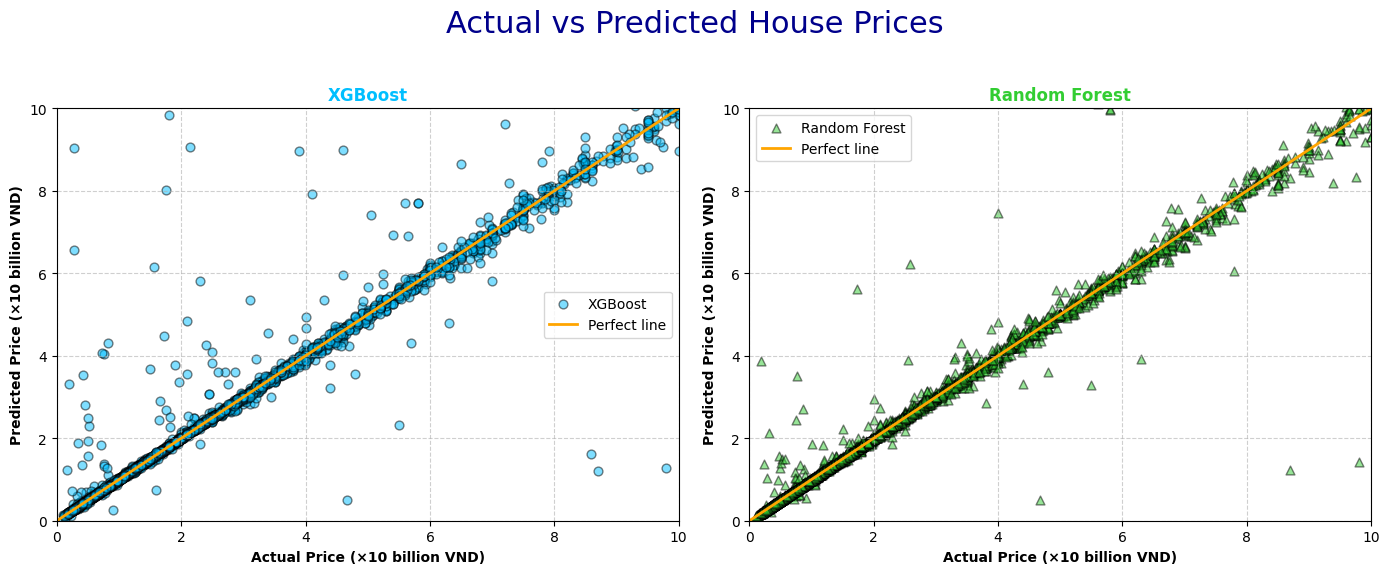

In [10]:
# -------------------------------------------------
# 8. MINH HỌA SCATTER ACTUAL vs PREDICTED
# -------------------------------------------------
import matplotlib.pyplot as plt

# Giả sử bạn đã có biến rf_pred  (kết quả Random Forest)
models = [("XGBoost", xgb_pred, "deepskyblue", "o"),
          ("Random Forest", rf_pred, "limegreen",   "^")]

plt.figure(figsize=(14,6))
for i, (name, pred, color, marker) in enumerate(models, 1):
    plt.subplot(1,2,i)
    plt.scatter(y_test/10, pred/10, c=color, marker=marker,
                s=40, edgecolors="black", alpha=0.5, label=name)
    plt.plot([0,10], [0,10], "orange", lw=2, label="Perfect line")
    plt.xlim(0,10); plt.ylim(0,10)
    plt.xlabel("Actual Price (×10 billion VND)", fontweight="bold")
    plt.ylabel("Predicted Price (×10 billion VND)", fontweight="bold")
    plt.title(name, fontweight="bold", color=color)
    plt.grid(ls="--", alpha=0.6); plt.legend()

plt.suptitle("Actual vs Predicted House Prices", fontsize=22, color="darkblue")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

In [11]:
# -------------------------------------------------
# 9. IMPORT THƯ VIỆN
# -------------------------------------------------
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import (mean_squared_error,
                             mean_squared_log_error, r2_score)
import numpy as np

In [12]:
# -------------------------------------------------
# 10. BASE MODEL (đều bọc trong pipeline có 'prep')
# -------------------------------------------------
xgb_pipe = Pipeline([
        ("prep", preprocess),
        ("xgb",  XGBRegressor(**study.best_params))
])

rf_pipe = Pipeline([
        ("prep", preprocess),
        ("rf",   RandomForestRegressor(**study.best_params))
])

In [13]:
# -------------------------------------------------
# 11. META‑MODEL  (RidgeCV cho chắc chắn)
# -------------------------------------------------
meta_model = RidgeCV(alphas=np.logspace(-3,3,13))

In [14]:
# -------------------------------------------------
# 12. STACKING REGRESSION  (K=10 fold, shuffle)
# -------------------------------------------------
stack = StackingRegressor(
        estimators=[('xgb', xgb_pipe),
                    ('rf', rf_pipe)],
        final_estimator=meta_model,
        cv=KFold(n_splits=10, shuffle=True, random_state=42),
        n_jobs=-1,
        passthrough=False    # chỉ dùng dự báo base model
)

In [15]:
# -------------------------------------------------
# 13. HUẤN LUYỆN
# -------------------------------------------------
stack.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:13:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[13:18:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[13:18:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[13:18:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[13:18:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[13:18:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "mi

StackingRegressor(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                  estimators=[('xgb',
                               Pipeline(steps=[('prep',
                                                ColumnTransformer(transformers=[('num',
                                                                                 StandardScaler(),
                                                                                 Index(['price_per_m2', 'area', 'floors', 'toilets', 'bedrooms', 'balcony',
       'street_frontage', 'legal', 'interior', 'year', 'month', 'day'],
      dtype='object')),
                                                                                ('bool',
                                                                                 'passthrough',
                                                                                 Index(['distric...
                                                RandomForestRegressor(bootstrap=False,
                                                                      max_depth=27,
                                                                      max_features=0.9827964233432697,
                                                                      min_samples_split=3,
                                                                      n_estimators=1058))]))],
                  final_estimator=RidgeCV(alphas=array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])),
                  n_jobs=-1)

In [16]:
# -------------------------------------------------
# 14. ĐÁNH GIÁ DỰA TRÊN TẬP TEST
# -------------------------------------------------
pred_test = stack.predict(X_test)

rmse  = np.sqrt(mean_squared_error(y_test, pred_test))
rmsle = np.sqrt(mean_squared_log_error(
                    np.clip(y_test, 0, None)+1,
                    np.clip(pred_test, 0, None)+1))
r2    = r2_score(y_test, pred_test)

print(f"RMSE  : {rmse:,.3f}")
print(f"RMSLE : {rmsle:.3f}")
print(f"R²    : {r2:.4f}")

RMSE  : 19.946
RMSLE : 0.187
R²    : 0.8327


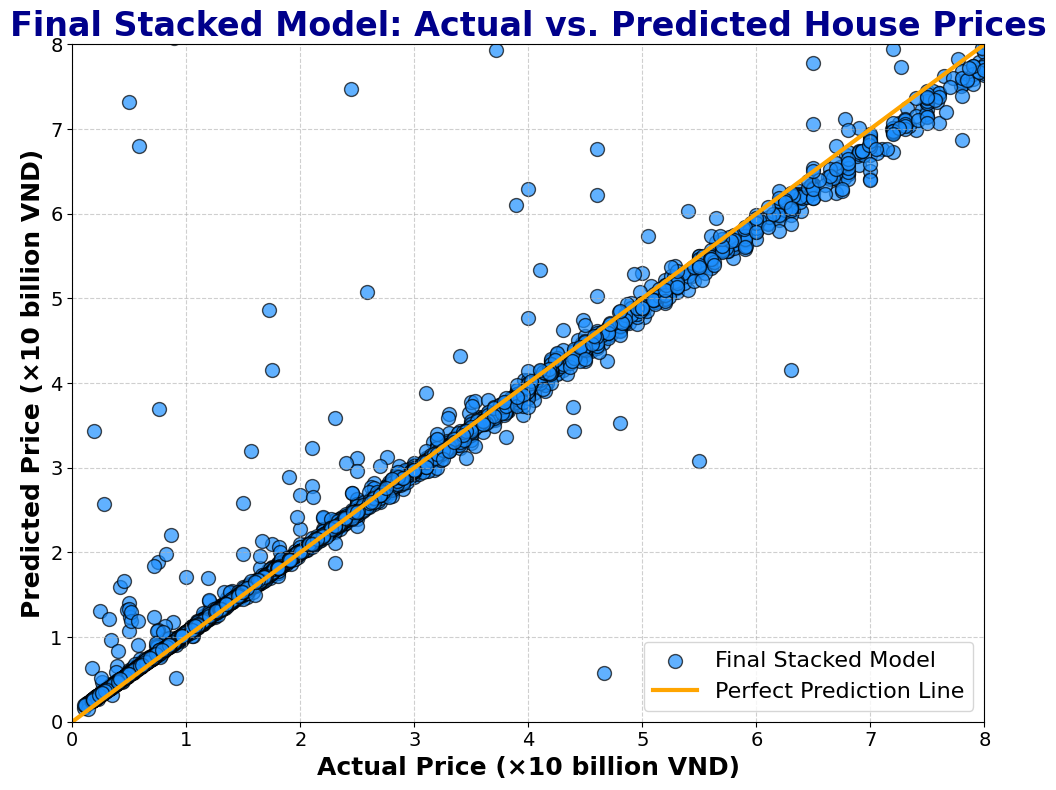

In [17]:
# -------------------------------------------------
# 15. VẼ SCATTER
# -------------------------------------------------
plt.figure(figsize=(10, 8))
plt.title("Final Stacked Model: Actual vs. Predicted House Prices", fontsize=24, fontweight='bold', color='darkblue')

plt.scatter(y_test / 10, pred_test / 10,
            color='dodgerblue', marker='o', edgecolors="black", alpha=0.7, s=100, label="Final Stacked Model")

plt.plot([0, 8], [0, 8], "orange", lw=3, label="Perfect Prediction Line")

plt.xlim(0, 8)
plt.ylim(0, 8)
plt.xlabel("Actual Price (×10 billion VND)", fontsize=18, fontweight='bold')
plt.ylabel("Predicted Price (×10 billion VND)", fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
# -------------------------------------------------
# 16. TRIỂN KHAI
# -------------------------------------------------
deploy_pred = stack.predict(X_test)
pd.DataFrame({"Price": deploy_pred}) \
  .to_csv("Submission_Stack_(Xgb+Rf).csv", index=False)

print("Saved file: Submission_Stack_(Xgb+Rf).csv")

Saved file: Submission_Stack_(Xgb+Rf).csv
